In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/newsData

/content/drive/MyDrive/newsData


In [ ]:
import pandas as pd

In [ ]:
import os
import pandas as pd 
import numpy as np

df = pd.read_csv('okt_data_sec.csv')

In [ ]:
# https://wikidocs.net/22660
# 원-핫 벡터는 표현하고자 하는 단어의 인덱스의 값만 1, 나머지 인덱스에는 전부 0으로 표현 
# = 각 단어 벡터간 유의미한 유사성을 표현할 수 없다는 단점
# 대안으로 단어의 의미를 다차원 공간에 벡터화하는 방법 : 분산 표현(distributed representation)
# 분산 표현을 이용하여 단어 간 의미적 유사성을 벡터화하는 작업을 워드 임베딩(embedding)
!pip install --upgrade gensim==4.1.2
import matplotlib.pyplot as plt

# df.isnull().values.any()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 843.5 kB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [ ]:
df

,content
0,"['태양광', '충전', '되는', '아이폰', '테슬라']"
1,"['지디', '코리아', '이정현', '기자', '도널드', '트럼프', '미국',..."
2,"['업체', '주로', '아이폰', '애플', '워치', '제품', '장식', '개..."
3,"['아이폰', '이름', '아이폰', '테슬라']"
4,"['제품', '태양', '전지', '패널', '있어', '스마트폰', '뒤집어', ..."
...,...
30231,['비해']
30232,"['지난', '대진', '침대', '매트리스', '연간', '피폭', '선량']"
30233,"['지속', '가능한', '패션', '오랫동안', '지적']"
30234,"['넘게', '클과', '만난', '적도', '없는', '알려졌다']"


In [ ]:

import random
import re, string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
df

,content
0,"['태양광', '충전', '되는', '아이폰', '테슬라']"
1,"['지디', '코리아', '이정현', '기자', '도널드', '트럼프', '미국',..."
2,"['업체', '주로', '아이폰', '애플', '워치', '제품', '장식', '개..."
3,"['아이폰', '이름', '아이폰', '테슬라']"
4,"['제품', '태양', '전지', '패널', '있어', '스마트폰', '뒤집어', ..."
...,...
30231,['비해']
30232,"['지난', '대진', '침대', '매트리스', '연간', '피폭', '선량']"
30233,"['지속', '가능한', '패션', '오랫동안', '지적']"
30234,"['넘게', '클과', '만난', '적도', '없는', '알려졌다']"


In [ ]:
# https://github.com/ssokeem/NewsletterBoard/blob/sojeong/2ndClustering/Modeling_and_Extract_Keyword.ipynb
# https://velog.io/@ssokeem/data-news-project-final

from sklearn.feature_extraction.text import TfidfVectorizer

#1 tf-idf 임베딩
tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5))

vector = tfidf_vectorizer.fit_transform(df['content']).toarray()

vector = np.array(vector)
     
vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
vector.shape

(30236, 44158)

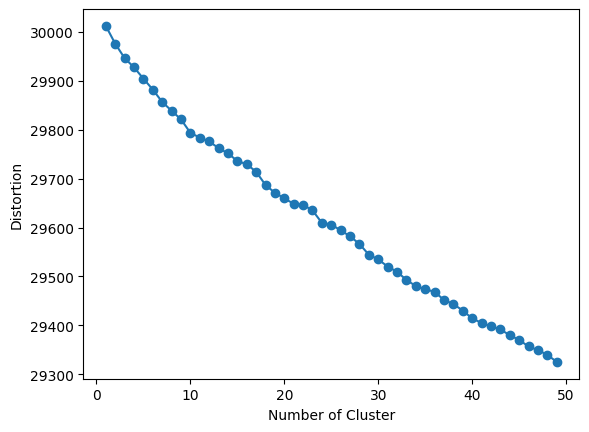

In [ ]:


#2 K-means clustering - Elbow method
def visualize_elbowmethod(data, param_init='random', param_n_init=20, param_max_iter=300):
    distortions = []
    for i in range(1, 50):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(range(1, 50), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

visualize_elbowmethod(vector)
     


In [ ]:


#3 K-means clustering - Silhouette Score
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(20,60)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector) # 가장 높은 실루엣 계수와 매핑되는 k
     


In [ ]:
# # K-Means Clustering

# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=25).fit(vector)
# print(kmeans.labels_)

In [ ]:
#2 DBSCAN Clustering

from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.5, min_samples=3, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result = model.fit_predict(vector)
df['cluster'] = result

cnt = [i for i  in range(93)]

for i in result:
  if i == -1:
    cnt[i] += 1
print(cnt)

print('군집개수 :', result.max())
df

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 22255]
군집개수 : 1729


,content,cluster
0,"['태양광', '충전', '되는', '아이폰', '테슬라']",0
1,"['지디', '코리아', '이정현', '기자', '도널드', '트럼프', '미국',...",-1
2,"['업체', '주로', '아이폰', '애플', '워치', '제품', '장식', '개...",-1
3,"['아이폰', '이름', '아이폰', '테슬라']",0
4,"['제품', '태양', '전지', '패널', '있어', '스마트폰', '뒤집어', ...",-1
...,...,...
30231,['비해'],2
30232,"['지난', '대진', '침대', '매트리스', '연간', '피폭', '선량']",1727
30233,"['지속', '가능한', '패션', '오랫동안', '지적']",1728
30234,"['넘게', '클과', '만난', '적도', '없는', '알려졌다']",1672


In [ ]:

#3 대표 기사 추출

def print_cluster_result(train):
    clusters = []
    counts = []
    top_title = []
    top_noun = []
    for cluster_num in set(result):
        # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
        # if(cluster_num == -1 or cluster_num == 0): 
        #     continue
        # else:
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train['cluster1st'] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            top_title.append(temp_df.reset_index()['Title'][0])
            top_noun.append(temp_df.reset_index()['noun'][0]) # 군집별 첫번째 기사를 대표기사로 ; tfidf방식
            for title in temp_df['Title']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'top_title':top_title, 'top_noun':top_noun})
    return cluster_result

In [ ]:
df['cluster'] = kmeans.labels_

In [ ]:
df

In [ ]:


for cluster_num in set(df['cluster']):
  temp_df = df[df['cluster'] == cluster_num]
  print("cluster num : {} Number of news : {}".format(cluster_num, len(temp_df)))
  for title in temp_df['0']:
    print(title)
  print()
     


In [ ]:
for cluster_num in set(df['cluster']):
  temp_df = df*df['cluster'] == cluster_num
  print("cluster num : {} Number of news : {}".format(cluster_num, len(temp_df)))

In [ ]:


keyword = []
for word_list in df['0']:
  words = []
  for word in word_list.split(' '):
    words.append(word)
  key = Counter(words).most_common(1)
  keyword.append(key)

keyword
     


In [ ]:
# 키워드 추출할 대상 문서만 new_doc에 넣어서 해야함 - 이것도 클러스터 개수만큼 loop 돌려서?

new_vector = tfidf_vectorizer.transform(new_doc).toarray()

ture_names = tfidf_vectorizer.get_feature_names() # 단어 목록
sorted_idx = new_vector.argsort()[:, ::-1] # TF-IDF 내림차순 정렬

for i in range(5): # 상위 5개 단어 추출
    print(feature_names[sorted_idx[0, i]])
